# Ecommerce: reverse image search

All the ecommerce platforms need a search mechanism. The built-in methods usually relies on some variation of full-text search which finds the relevant documents based on a presence of the words used in a query. In some cases it might be enough, but there are ways to improve that mechanism, and so to increase the number of sales. If your customer is able to find a product they need, they are more likely to buy it.

Semantic search is one of the possibilities. It relies not only on keywords, but considers the meaning and intention of the query. However, if you want to enable non-textual search capabilities, reverse image search might be a way to go. Your customers may struggle with expressing themselves, so why don't you ease that and start accepting images as your search queries?

# Amazon product dataset 2020

We're going to use [Amazon product dataset 2020](https://www.kaggle.com/datasets/promptcloud/amazon-product-dataset-2020/) and see how to enable visual queries for it. The following lines will download it from cloud and create a directory structure, so you can reproduce the results on your own.

In [31]:
!mkdir data
!mkdir data/images
!wget -nc --directory-prefix=data/ "https://storage.googleapis.com/qdrant-examples/amazon-product-dataset-2020.zip"

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/images’: File exists
File ‘data/amazon-product-dataset-2020.zip’ already there; not retrieving.



In [2]:
!pip install -r requirements.txt

The dataset is provided as a CSV file and contains multiple attributes of the products, including URLs of the product images. That gives us a real case to work on. Let's check the dataset structure and prepare it for the futher processing.

In [3]:
import pandas as pd
import zipfile

with zipfile.ZipFile("./data/amazon-product-dataset-2020.zip", "r") as z:
    with z.open("home/sdf/marketing_sample_for_amazon_com-ecommerce__20200101_20200131__10k_data.csv") as f:
        dataset_df = pd.read_csv(f)
        
dataset_df.sample(n=5).T

,8058,4057,8297,3008,2659
Uniq Id,24912bea6167ee1cfc2e1c65c97564ba,77b4a54b1b56a9adc206f614e6a98901,e37c0d1ed1e575ab47fd8f5a13bdc138,efe6ab941d0367fa78c4e78a2d1dfada,a0765fcea73c069e3874d7859483b79d
Product Name,Smith Safety Gear Scabs Knee/Elbow/Wrist Guard...,ScienceWiz / Inventions Kit,"Cardinal Gates Kid's Edge Metal Hearth Guard, ...","Amscan 241286 Party Décor, Multi Size, Multicolor",Melissa & Doug Examine & Treat Pet Vet Play Se...
Brand Name,NaN,NaN,NaN,NaN,NaN
Asin,NaN,NaN,NaN,NaN,NaN
Category,Sports & Outdoors | Outdoor Recreation | Skate...,Toys & Games | Learning & Education | Science ...,Home & Kitchen | Furniture | Kids' Furniture,Toys & Games | Party Supplies,Toys & Games | Dress Up & Pretend Play | Prete...
Upc Ean Code,NaN,NaN,NaN,NaN,NaN
List Price,NaN,NaN,NaN,NaN,NaN
Selling Price,$22.95 - $45.32,$17.80,$78.82,$9.69,$46.80
Quantity,NaN,NaN,NaN,NaN,NaN
Model Number,NaN,7901,KE-IVR-C,241286,NaN


In [4]:
dataset_df.shape

(10002, 28)

In [5]:
dataset_df.iloc[0]["Image"]

'https://images-na.ssl-images-amazon.com/images/I/51j3fPQTQkL.jpg|https://images-na.ssl-images-amazon.com/images/I/31hKM3cSoSL.jpg|https://images-na.ssl-images-amazon.com/images/I/51WlHdwghfL.jpg|https://images-na.ssl-images-amazon.com/images/I/51FsyLRBzwL.jpg|https://images-na.ssl-images-amazon.com/images/G/01/x-locale/common/transparent-pixel.jpg'

It turns out, a single product may have several images. They are stored in a pipe-separated string.

In [6]:
dataset_df.iloc[0]["Image"].split("|")

['https://images-na.ssl-images-amazon.com/images/I/51j3fPQTQkL.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/31hKM3cSoSL.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51WlHdwghfL.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51FsyLRBzwL.jpg',
 'https://images-na.ssl-images-amazon.com/images/G/01/x-locale/common/transparent-pixel.jpg']

The last entry is common for multiple products, so we can simply remove it.

In [7]:
dataset_df["Image"] = dataset_df["Image"].map(lambda x: x.split("|")[:-1])

In [8]:
dataset_df.iloc[0]["Image"]

['https://images-na.ssl-images-amazon.com/images/I/51j3fPQTQkL.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/31hKM3cSoSL.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51WlHdwghfL.jpg',
 'https://images-na.ssl-images-amazon.com/images/I/51FsyLRBzwL.jpg']

In [9]:
dataset_df = dataset_df.explode("Image").dropna(subset=["Image"])
dataset_df.sample(n=5).T

,3622,5266,2692,9680,8911
Uniq Id,e9afc9f6f7c55d684500804c880a1afe,f3980dd73e277b8643a320d9e862cb60,c7b6dad13d7c33e32f067becdf28bc3a,bf16a4a660e9ca5a0a11d24b4593de88,628587015db4b47bd98bbf7cbb6e9524
Product Name,Q WORKSHOP Classic Runic Glacier & Black Dice ...,Christian Lacroix Maison De Jeu 250 Piece 2 Si...,Funko Pop Movies: Silence of The Lambs - Hannibal,4M Kidzrobotix Doodling Robot - DIY Science En...,"Everest Deluxe Small Backpack, Black, One Size"
Brand Name,NaN,NaN,NaN,NaN,NaN
Asin,NaN,NaN,NaN,NaN,NaN
Category,Toys & Games | Games & Accessories | Game Acce...,Toys & Games | Puzzles | Jigsaw Puzzles,Toys & Games | Toy Figures & Playsets | Action...,Toys & Games | Learning & Education | Science ...,"Clothing, Shoes & Jewelry | Luggage & Travel G..."
Upc Ean Code,NaN,NaN,NaN,NaN,NaN
List Price,NaN,NaN,NaN,NaN,NaN
Selling Price,$7.00,$19.88,$7.84,$12.75,$15.26
Quantity,NaN,NaN,NaN,NaN,NaN
Model Number,SCLR2CQWS,NaN,41965,4575,7045S-BK


## Downloading the images

We want to create the embeddings out of the images, but we need to have them downloaded in the first place.

In [10]:
from typing import Optional

import urllib
import os

def download_file(url: str) -> Optional[str]:
    basename = os.path.basename(url)
    target_path = f"./data/images/{basename}"
    if not os.path.exists(target_path):
        try:
            urllib.request.urlretrieve(url, target_path)
        except urllib.error.HTTPError:
            return None
    return target_path

In [11]:
import numpy as np

dataset_df["LocalImage"] = dataset_df["Image"].map(download_file).replace({None: np.nan})
dataset_df = dataset_df.dropna(subset=["LocalImage"])
dataset_df.sample(n=5).T

,4454,6548,6454,5223,4901
Uniq Id,af11d5f530665e1500ec2dcfe72a6fe2,f1147389b44d0c6cf03d3a5ff4e1fd2f,bfbce68a8e07f20d1c056ce9654ed728,f44698849d2259a64957408815eaf2ff,c286cebd3a83b94ecaf625fb4632b423
Product Name,Leder Games Vast: The Mysterious Manor,Vera Bradley Women's Lighten Up Cooler Lunch Bag,"Brybelly 12 Decks (6 Red/6 Blue) Wide-Size, Ju...",Doc McStuffins Baby All in One Nursery Toy,Skywalker Trampolines Mini Trampoline with Enc...
Brand Name,NaN,NaN,NaN,NaN,NaN
Asin,NaN,NaN,NaN,NaN,NaN
Category,NaN,Home & Kitchen | Kitchen & Dining | Storage & ...,Toys & Games | Games & Accessories | Card Game...,NaN,Sports & Outdoors | Sports & Fitness | Leisure...
Upc Ean Code,NaN,NaN,NaN,NaN,NaN
List Price,NaN,NaN,NaN,NaN,NaN
Selling Price,$56.61,$38.00,$14.99,$24.99,"$61.81 - $9,999.99"
Quantity,NaN,NaN,NaN,NaN,NaN
Model Number,LED00006,NaN,NaN,92246,NaN


## Creating the embeddings

There are various options of how to create the embeddings out of our images. But do not even think about training your neural encoder from scratch! There are plenty of pretrained models available and some of them may already give you some decent results in your domain. And if not, you can use them as a base for the fine-tuning that might be done way faster than the full training.

### Available options

Using the pretrained models is easy if you choose a library that exposes them with a convenient interface. Some of the possibilites are:

- [torchvision](https://pytorch.org/vision/stable/index.html) - part of PyTorch
- [embetter](https://koaning.github.io/embetter/) - if you prefer using pandas-like API, that's a great choice
- [Sentence-Transformers](https://www.sbert.net/examples/applications/image-search/README.html) - one of the standard libraries for NLP exposes OpenAI CLIP model as well 

### Choosing the right model

If you run an ecommerce business, you probably have a standard full-text search mechanism already in place. Reverse image search is one option to enrich the user experience, but if you also want to experiment with [hybrid search](https://qdrant.tech/articles/hybrid-search/), then you should keep that in mind from the very beginning. If that's your scenario it's better to consider multimodality from day one. Such a model can encode both texts and images in the same vector space.

For that reason, we are going to use the OpenAI CLIP model, so in the future we can extend our search mechanism with semantic search using the same component.

In [12]:
from sentence_transformers import SentenceTransformer
from PIL import Image

model = SentenceTransformer("clip-ViT-B-32")

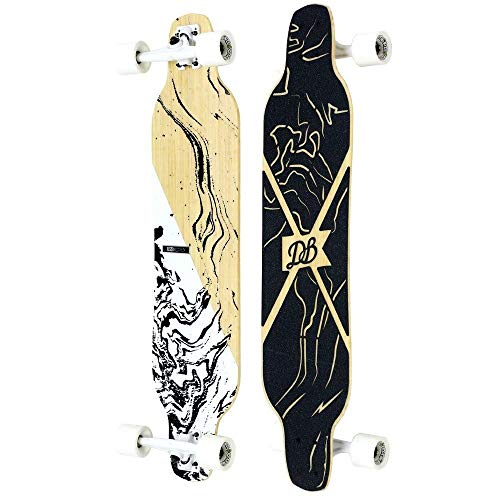

In [13]:
image = Image.open(dataset_df.iloc[0]["LocalImage"])
image

In [14]:
image_embedding = model.encode(image)
image_embedding.shape

(512,)

In [15]:
image_embedding

array([-1.65571928e-01,  1.54125392e-02,  2.85299793e-02,  2.85897315e-01,
       -9.77889523e-02,  3.51723172e-02, -8.21444839e-02,  3.13845724e-01,
        5.39577603e-01, -2.35730596e-02, -1.49792001e-01, -3.49237733e-02,
        3.13195139e-01,  1.07492872e-01,  3.35926920e-01, -1.74858257e-01,
       -3.12612116e-01, -2.49689266e-01,  1.21360891e-01, -4.06032681e-01,
       -5.85119307e-01,  5.54444268e-03,  1.62412554e-01, -2.13321298e-02,
       -1.13875970e-01,  6.79319859e-01,  2.05873370e-01, -1.55175477e-03,
       -1.06999934e-01, -4.35025990e-03,  1.93583339e-01, -2.21737057e-01,
       -3.60848993e-01,  1.50151193e-01, -7.05900431e-01, -1.43698573e-01,
        4.62083012e-01,  1.36016995e-01, -6.54759407e-02,  1.15651941e+00,
       -5.72706580e-01, -7.77218193e-02,  2.85190463e-01, -4.62993607e-02,
        2.94625968e-01, -6.38354063e-01, -1.73545390e-01,  2.20517874e-01,
        1.75905973e-01, -4.11976993e-01, -3.15201491e-01,  5.13477147e-01,
       -7.56976008e-02,  

That's how a single embedding look like. But we need to calculate them for each image in our dataset.

In [16]:
from typing import List

def calculate_embedding(image_path: str) -> Optional[List[float]]:
    try:
        image = Image.open(image_path)
        return model.encode(image).tolist()
    except:
        return None

In [17]:
dataset_df["Embedding"] = dataset_df["LocalImage"].map(calculate_embedding)
dataset_df["Embedding"] = dataset_df["Embedding"].replace({None: np.nan})
dataset_df = dataset_df.dropna(subset=["Embedding"])
dataset_df.sample(n=5).T

,9381,9843,8421,7244,7493
Uniq Id,f3ca6aa57228ae1652e8f4f2c6dd8947,cd7e48aa11c52fbb28e4e389c4dee55e,76e3efda1963b61f578f1084de0e5e48,c36d2fb627c494914b4f7bdf08faf510,b2e8d5d21244b3c6acbbf9a88a69366e
Product Name,Ceaco Crowd Pleasers Collection by Jan Van Haa...,HobbyWing Automobile 30401150 Xerun Sct 3660 S...,Hot Wheels Boys Dynacraft Bike with Turbospoke...,Rollerblade Macroblade 84 ABT Women's Adult Fi...,MightySkins Skin Compatible with Parrot Bebop ...
Brand Name,NaN,NaN,NaN,NaN,NaN
Asin,NaN,NaN,NaN,NaN,NaN
Category,Toys & Games | Puzzles | Jigsaw Puzzles,Remote & App Controlled Vehicle Parts | Power ...,Sports & Outdoors | Outdoor Recreation | Cycli...,Sports & Outdoors | Outdoor Recreation | Skate...,Toys & Games | Hobbies | Remote & App Controll...
Upc Ean Code,NaN,NaN,NaN,NaN,NaN
List Price,NaN,NaN,NaN,NaN,NaN
Selling Price,$15.54,$143.48,$79.99,$62.49,NaN
Quantity,NaN,NaN,NaN,NaN,NaN
Model Number,3342-23,NaN,8008-06ZTJ,07734500986,PABEBOP-Blue Camo


In [18]:
dataset_df.to_parquet("./data/amazon-with-embeddings.parquet")

## Indexing embeddings in Qdrant

Reverse image search is based on comparing the embeddings of the image used as a query and the embeddings of the indexed pictures. That can be theoretically done in a naive way, by comparing the query to every single item from our store, but that won't scale if we even go beyond a few hundreds. That's what the vector search engines are designed for. Qdrant acts as a fast retrieval layer which performs an efficient search for the closest vectors in the space.

There are various ways on how to start using Qdrant, and even though the local mode in Python SDK is possible, in production it should be running as a service. The easiest way is to use a Docker container, and so we'll do.

In [21]:
!docker run -d -p "6333:6333" -p "6334:6334" --name "reverse_image_search" qdrant/qdrant:v1.3.0

b1bf3ac497c5c8b6d4cfde2d45494cee7dd6590ff021e0b597be769b4543af22


In [22]:
from qdrant_client import QdrantClient
from qdrant_client.http import models as rest

client = QdrantClient("localhost")
client.get_collections()

CollectionsResponse(collections=[])

In [23]:
client.recreate_collection(
    collection_name="amazon",
    vectors_config=rest.VectorParams(
        size=512,
        distance=rest.Distance.COSINE,
    )
)

True

It's a good practice to use batching while inserting the vectors into the collection. Python SDK has a utility method which performs it automatically. For the purposes of our demo we're going to store vectors with the product id, name and description as a payload.

In [24]:
payloads = dataset_df[["Uniq Id", "Product Name", "About Product", "LocalImage"]] \
    .fillna("Unknown") \
    .rename(columns={"Uniq Id": "ID", 
                     "Product Name": "Name", 
                     "About Product": "Description",
                     "LocalImage": "Path"}) \
    .to_dict("records")
payloads[0]

{'ID': '4c69b61db1fc16e7013b43fc926e502d',
 'Name': 'DB Longboards CoreFlex Crossbow 41" Bamboo Fiberglass Longboard Complete',
 'Description': "Make sure this fits by entering your model number. | RESPONSIVE FLEX: The Crossbow features a bamboo core encased in triaxial fiberglass and HD plastic for a responsive flex pattern that’s second to none. Pumping & carving have never been so satisfying! Flex 2 is recommended for people 120 to 170 pounds. | COREFLEX TECH: CoreFlex construction is water resistant, impact resistant, scratch resistant and has a flex like you won’t believe. These boards combine fiberglass, epoxy, HD plastic and bamboo to create a perfect blend of performance and strength. | INSPIRED BY THE NORTHWEST: Our founding ideal is chasing adventure & riding the best boards possible, inspired by the hills, waves, beaches & mountains all around our headquarters in the Northwest | BEST IN THE WORLD: DB was founded out of sheer love of longboarding with a mission to create the 

In [25]:
import uuid

client.upload_collection(
    collection_name="amazon",
    vectors=dataset_df["Embedding"].tolist(),
    payload=payloads,
    ids=[uuid.uuid4().hex for _ in payloads],
)

In [26]:
client.count("amazon")

CountResult(count=33735)

## Running the reverse image search

As soon as we have the data indexed in Qdrant, it may already start acting as our reverse image search mechanism. Our queries no longer can be just textual, but we can freely use images to find some similar items. For that, we surely need a query, and that will rarely be an image from the dataset. Let's find some different examples - for example from [Unsplash](https://unsplash.com), which is a source of freely usable images.

In [27]:
import ipyplot
import glob

query_image_paths = list(glob.glob("./queries/*"))
ipyplot.plot_images(query_image_paths, img_width=150)

In [28]:
for query_image_path in query_image_paths:
    query_image = Image.open(query_image_path)
    query_embedding = model.encode(query_image)
    
    results = client.search(
        collection_name="amazon",
        query_vector=query_embedding,
        with_payload=True,
        limit=5,
    )
    
    output_images = [query_image_path]
    custom_texts = ["Query"]
    for result in results:
        output_images.append(result.payload["Path"])
        custom_texts.append(f"{result.payload['Name']} ({result.score})")
        
    ipyplot.plot_images(output_images, custom_texts=custom_texts, img_width=150)

We've implemented a reverse image search mechanism for e-commerce within a single notebook. We can kill the running Docker container for now, so nothing is left dangling in our environment.

In [29]:
!docker kill reverse_image_search
!docker rm reverse_image_search

reverse_image_search
reverse_image_search


## Futher steps

The notebook shows the general pipeline of encoding the inventory and using Qdrant to perform the reverse image search. There are, however, some challenges you may encounter while trying to implement it in real world:.

1. Pretrained models are great to start with, but may struggle for some specific kinds of inventory, if not trained on similar example. You can always fine-tune them with small amounts of data to avoid full training cycle. 
2. Models should not be hosted within Jupyter notebooks, but there are some ways of how to serve them in an efficient way. We're going to describe the possibilities in a separate tutorial.
3. If you don't want to worry about maintaining another system in your stack, please consider using [Qdrant Cloud](https://cloud.qdrant.io/), our managed solution. Free tier is free forever and available to everyone, no credit card required.